<a href="https://colab.research.google.com/github/nagarjuna741621/ML/blob/main/PartA__AP23110011370.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [ ]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [ ]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [ ]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [ ]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [ ]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [ ]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

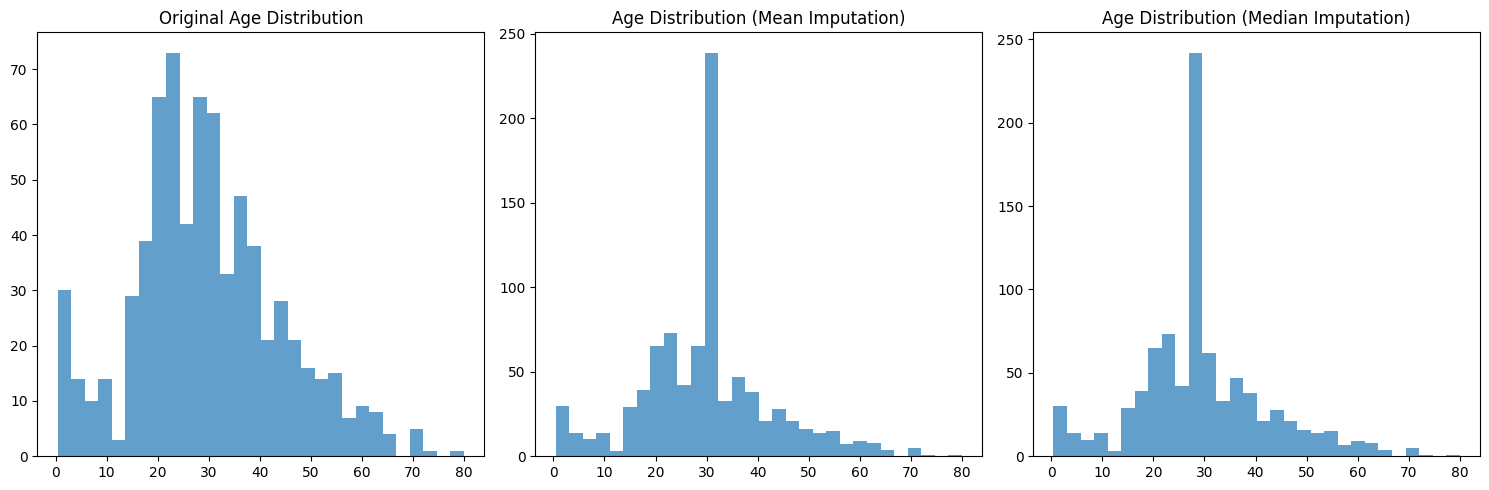

Original Age mean: 29.69911764705882
Age after Mean Imputation mean: 29.69911764705882
Age after Median Imputation mean: 29.36158249158249

Original Age median: 28.0
Age after Mean Imputation median: 29.69911764705882
Age after Median Imputation median: 28.0


In [ ]:
# Exercise 2 - Part 1: Mean vs Median imputation for Age
df_age_mean = df.copy()
df_age_median = df.copy()

# Impute with mean
mean_age = df_age_mean['Age'].mean()
df_age_mean['Age'] = df_age_mean['Age'].fillna(mean_age)

# Impute with median
median_age = df_age_median['Age'].median()
df_age_median['Age'] = df_age_median['Age'].fillna(median_age)

# Plot histograms to compare
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df['Age'].dropna(), bins=30, alpha=0.7)
axes[0].set_title('Original Age Distribution')

axes[1].hist(df_age_mean['Age'], bins=30, alpha=0.7)
axes[1].set_title('Age Distribution (Mean Imputation)')

axes[2].hist(df_age_median['Age'], bins=30, alpha=0.7)
axes[2].set_title('Age Distribution (Median Imputation)')

plt.tight_layout()
plt.show()

print("Original Age mean:", df['Age'].mean())
print("Age after Mean Imputation mean:", df_age_mean['Age'].mean())
print("Age after Median Imputation mean:", df_age_median['Age'].mean())

print("\nOriginal Age median:", df['Age'].median())
print("Age after Mean Imputation median:", df_age_mean['Age'].median())
print("Age after Median Imputation median:", df_age_median['Age'].median())

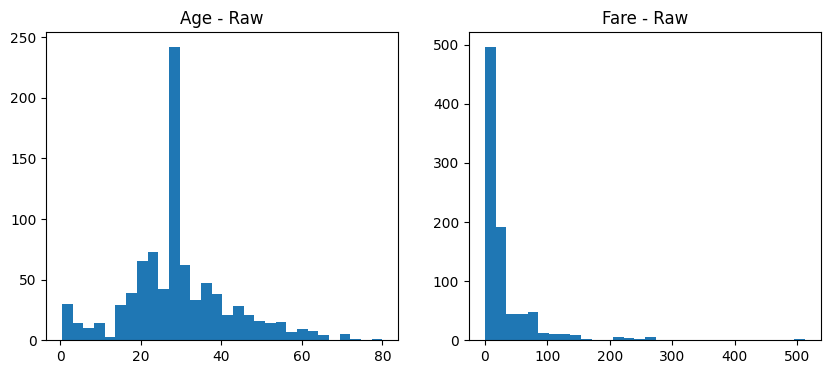

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

In [ ]:
# Exercise 2 - Part 2: Filling Embarked with 'Unknown' vs Mode
df_embarked_unknown = df.copy()
df_embarked_mode = df.copy()

# Fill with 'Unknown'
df_embarked_unknown['Embarked'] = df_embarked_unknown['Embarked'].fillna('Unknown')

# Fill with mode
mode_embarked = df_embarked_mode['Embarked'].mode()[0]
df_embarked_mode['Embarked'] = df_embarked_mode['Embarked'].fillna(mode_embarked)

print("Value counts for Embarked (filled with 'Unknown'):")
print(df_embarked_unknown['Embarked'].value_counts())

print("\nValue counts for Embarked (filled with Mode):")
print(df_embarked_mode['Embarked'].value_counts())

Value counts for Embarked (filled with 'Unknown'):
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

Value counts for Embarked (filled with Mode):
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

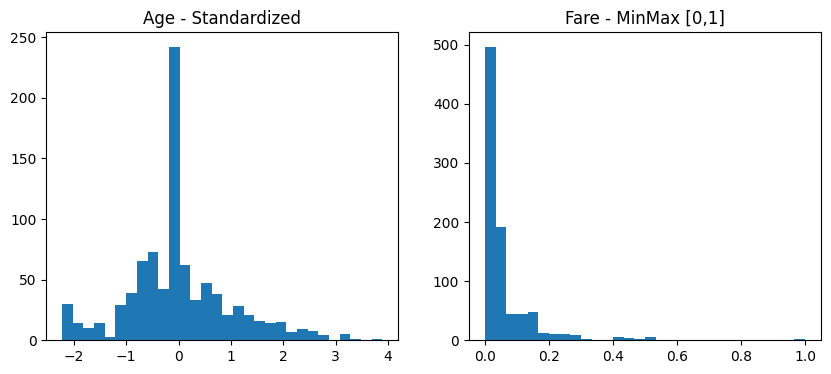

In [ ]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

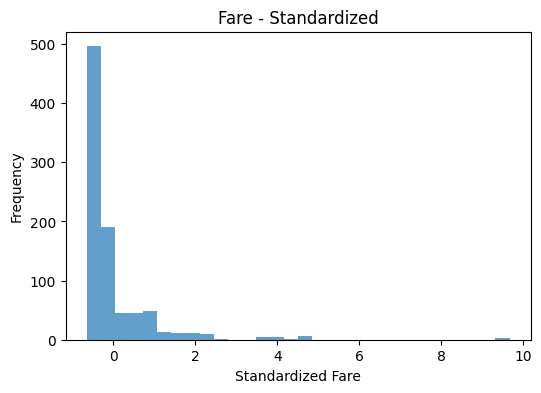

In [ ]:
# Exercise 3 - Part 1: Standardize Fare and plot the histogram
sc_std_fare = StandardScaler()

# Use df_imp as it has imputed values
fare_std = sc_std_fare.fit_transform(df_imp[['Fare']])

plt.figure(figsize=(6,4))
plt.hist(fare_std.flatten(), bins=30, alpha=0.7)
plt.title('Fare - Standardized')
plt.xlabel('Standardized Fare')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Exercise 3 - Part 2: Apply Normalizer on [Age, Fare] rows
normalizer = Normalizer()

# Use df_imp with imputed Age and Fare
age_fare_normalized = normalizer.fit_transform(df_imp[['Age', 'Fare']])

print("First 5 normalized vectors for [Age, Fare]:")
print(age_fare_normalized[:5])

First 5 normalized vectors for [Age, Fare]:
[[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [ ]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [ ]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [ ]:
# Demonstrate number of features for Embarked with Ordinal Encoding
enc_ord = OrdinalEncoder()
embarked_ord_demo = df_imp[['Embarked']].copy()
embarked_ord_vals = enc_ord.fit_transform(embarked_ord_demo)
print("Number of features with Ordinal Encoding for Embarked:", embarked_ord_vals.shape[1])

Number of features with Ordinal Encoding for Embarked: 1


In [ ]:
# Demonstrate number of features for Embarked with One-Hot Encoding
ohe_embarked_demo = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
print("Number of features with One-Hot Encoding for Embarked:", ohe_embarked_demo.shape[1])

Number of features with One-Hot Encoding for Embarked: 3


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

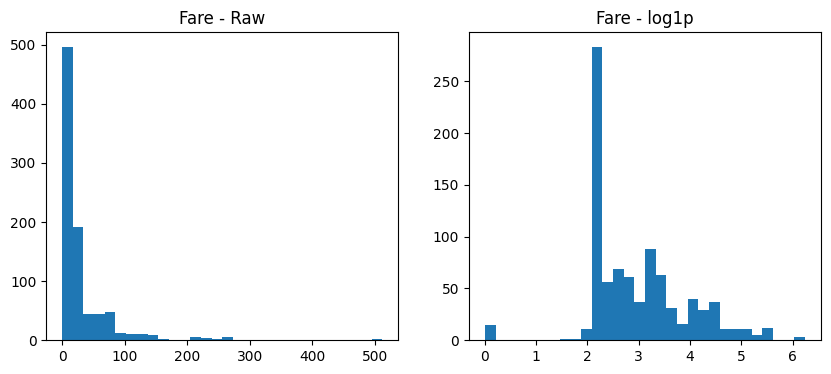

In [ ]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

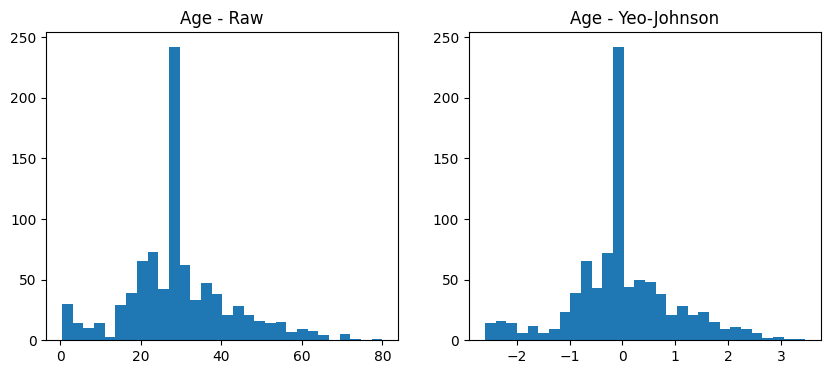

In [ ]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [ ]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

Skewness of numeric columns:
 Fare           4.787317
SibSp          3.695352
Parch          2.749117
Age            0.510245
Survived       0.478523
PassengerId    0.000000
Pclass        -0.630548
dtype: float64


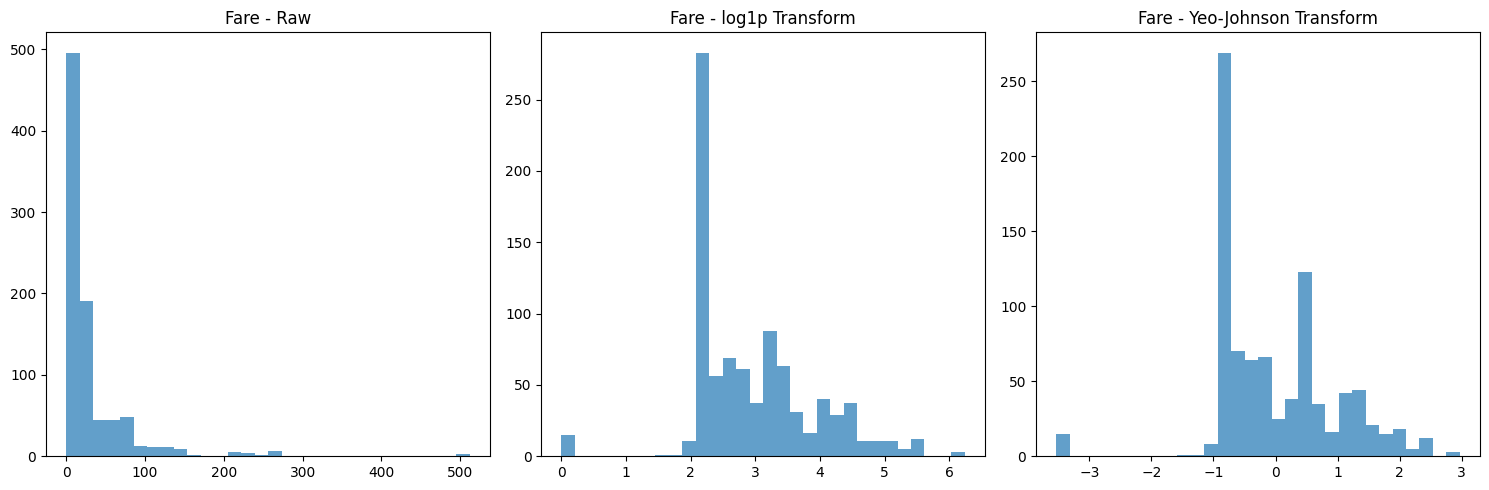

In [ ]:
# Exercise 5 - Part 1: Identify skewed column and apply transforms

# Check skewness of numeric columns
numeric_cols = df_imp.select_dtypes(include=np.number).columns
skewness = df_imp[numeric_cols].skew().sort_values(ascending=False)
print("Skewness of numeric columns:\n", skewness)

# 'Fare' is highly skewed, as seen from the skewness values and previous plots.
# We will use 'Fare' for this exercise.

fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)

# Log transform
fare_log = np.log1p(fare_raw)

# Power transform (Yeo-Johnson as Fare includes zero)
pt_fare = PowerTransformer(method='yeo-johnson')
fare_pt = pt_fare.fit_transform(fare_raw)

# Plot histograms to compare
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(fare_raw.flatten(), bins=30, alpha=0.7)
axes[0].set_title('Fare - Raw')

axes[1].hist(fare_log.flatten(), bins=30, alpha=0.7)
axes[1].set_title('Fare - log1p Transform')

axes[2].hist(fare_pt.flatten(), bins=30, alpha=0.7)
axes[2].set_title('Fare - Yeo-Johnson Transform')

plt.tight_layout()
plt.show()

**Answer to Exercise 5, Part 2:**

With `PolynomialFeatures(degree=2)` applied to `[Age, Fare]`, the new terms created are:

*   `Age^2`
*   `Age Fare`
*   `Fare^2`

These are in addition to the original `Age` and `Fare` terms.

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


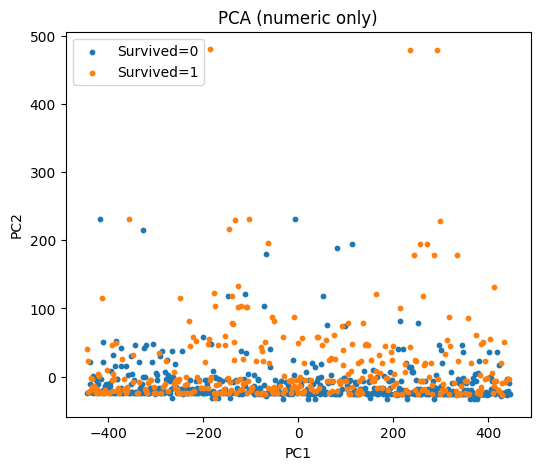

In [ ]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [ ]:
# Exercise 6 - Part 1: Which two numeric columns contribute the most variance?

# Calculate variance of numeric columns in df_imp (with imputed values)
numeric_cols = df_imp.select_dtypes(include=np.number)
variance = numeric_cols.var().sort_values(ascending=False)
print("Variance of numeric columns:\n", variance)

print("\nThe two numeric columns with the most variance are:", variance.index[:2].tolist())

Variance of numeric columns:
 PassengerId    66231.000000
Fare            2469.436846
Age              169.512498
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64

The two numeric columns with the most variance are: ['PassengerId', 'Fare']


In [ ]:
# Exercise 6 - Part 2: Try PCA with n_components=3 and print cumulative explained variance

# Prepare numeric-only frame (using df_imp with imputed values for consistency)
num_only_imp = df_imp.select_dtypes(include=['number']).dropna()

pca_3 = PCA(n_components=3, random_state=42)
Z_3 = pca_3.fit_transform(num_only_imp.values)

print("Explained variance ratios with 3 components:", pca_3.explained_variance_ratio_)
print("Cumulative explained variance with 3 components:", np.sum(pca_3.explained_variance_ratio_))

Explained variance ratios with 3 components: [0.96165195 0.03587775 0.0024362 ]
Cumulative explained variance with 3 components: 0.9999659003439996


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

Explained variance ratio for 2 components: [0.44577203 0.27550971]


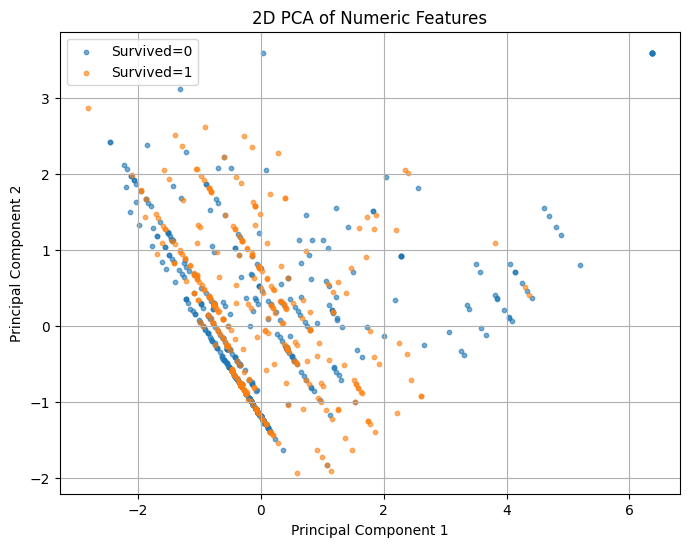


Accuracy of Simple Logistic Regression Model: 0.7982


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Start with the original dataframe
df_processed = df.copy()

# 1. Impute: Age (median), Embarked (mode), Cabin ('Unknown').
df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])
df_processed['Cabin'] = df_processed['Cabin'].fillna('Unknown')

# Select features and target
features = ['Age', 'Fare', 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch']
target = 'Survived' # Assuming 'Survived' is the target

# Create a new dataframe for processing selected features
df_encoded = df_processed[features].copy()


# Identify numeric and categorical columns for processing
numeric_features = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
categorical_features = ['Sex', 'Embarked']

# Apply Scaling and Transformation to numeric features
# Ensure numeric columns are float type for transformations
for col in numeric_features:
    df_encoded[col] = df_encoded[col].astype(float)


# 4. Transform: log1p Fare.
# Apply log1p BEFORE scaling Fare for better practice
df_encoded['Fare'] = np.log1p(df_encoded['Fare'])


# 2. Scale: standardize Age and min-max scale Fare.
scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

df_encoded['Age'] = scaler_std.fit_transform(df_encoded[['Age']])
df_encoded['Fare'] = scaler_mm.fit_transform(df_encoded[['Fare']]) # MinMax scale the log-transformed Fare


# 3. Encode: one-hot Sex and Embarked.
df_encoded = pd.get_dummies(df_encoded, columns=categorical_features, drop_first=True) # drop_first to avoid multicollinearity

# Now df_encoded contains the fully processed features

# 5. (Optional) PCA on numeric subset for 2D visualization.
# Select only numeric columns for PCA (after encoding, booleans are treated as numeric)
numeric_cols_for_pca = df_encoded.select_dtypes(include=np.number).columns.tolist()

# Exclude the target variable 'Survived' if it's still in df_encoded
if target in numeric_cols_for_pca:
    numeric_cols_for_pca.remove(target)

num_data_for_pca = df_encoded[numeric_cols_for_pca].dropna() # Drop NaNs just for PCA visualization if any were introduced


pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(num_data_for_pca)

print("Explained variance ratio for 2 components:", pca.explained_variance_ratio_)


# Plot PCA results, colored by Survived
# Need to ensure the index of pca_2d aligns with the original df_processed for getting 'Survived'
# Since we dropped NaNs for PCA, we use the index of num_data_for_pca
y_for_pca_plot = df_processed.loc[num_data_for_pca.index, target] if target in df_processed.columns else None


plt.figure(figsize=(8, 6))
if y_for_pca_plot is not None:
    idx0 = (y_for_pca_plot.values == 0)
    idx1 = (y_for_pca_plot.values == 1)
    plt.scatter(pca_2d[idx0, 0], pca_2d[idx0, 1], s=10, label=f'{target}=0', alpha=0.6)
    plt.scatter(pca_2d[idx1, 0], pca_2d[idx1, 1], s=10, label=f'{target}=1', alpha=0.6)
    plt.legend()
else:
    plt.scatter(pca_2d[:, 0], pca_2d[:, 1], s=10, alpha=0.6)

plt.title('2D PCA of Numeric Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Prepare data for Logistic Regression
# Assuming 'Survived' is the target and was NOT included in the features for processing
# If 'Survived' is still in df_encoded, separate it
if target in df_encoded.columns:
    X_model = df_encoded.drop(columns=[target])
    y_model = df_encoded[target]
else:
    X_model = df_encoded
    y_model = df_processed[target] # Get target from the dataframe after initial imputation


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.25, random_state=42)

# Train a simple Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42) # liblinear is good for small datasets
model.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy of Simple Logistic Regression Model: {accuracy:.4f}")